<a href="https://colab.research.google.com/github/AI-Isaiah/AI-Isaiah/blob/main/20230412_ensemble_weighted_method_with_smote_optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [11]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, StackingClassifier, VotingClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import ElasticNetCV
from sklearn.svm import SVC
!pip install optuna
!pip install catboost
!pip install shap
#!pip install verstack
#from verstack import LGBMTuner
import warnings
import seaborn as sns
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from xgboost import XGBClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from lightgbm.callback import early_stopping, log_evaluation
from sklearn.pipeline import Pipeline
import sys
import os
import lightgbm as lgbm
import logging
sys.path.append('/bin/sample_data')
sys.path.append('/root')
#from preprocessor import generate_cm
from collections import Counter
from sklearn.ensemble import VotingClassifier
import optuna
import pickle
import shap
import re
from sklearn.base import BaseEstimator, TransformerMixin
from functools import partial
from itertools import combinations
from copy import deepcopy

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV, ParameterSampler, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, mean_squared_error, precision_score, log_loss, f1_score, roc_auc_score, roc_curve, recall_score, accuracy_score, make_scorer,ConfusionMatrixDisplay,matthews_corrcoef, classification_report

from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import gc
import json
from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
def generate_cm1(y_true, y_pred, title = ""):
    y_pred = (y_pred > 0.5).astype(int)
    cm = confusion_matrix(y_true, y_pred)

    # Display confusion matrix using ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
    disp.plot()
    counter = Counter(y_true)
    for key, value in counter.items():
      print(f'{title}"{key}": {value}')

def roc_cm(y_test, y_pred_proba):
    """
    Compute and plot the ROC curve and confusion matrix for a binary classification problem.

    Args:
        y_test (ndarray): Ground truth (correct) target values.
        y_pred_proba (ndarray): Estimated probabilities or decision function.

    Returns:
        None
    """
    y_pred_binary = np.where(y_pred_proba[:, 1] >= 0.5, 1, 0)
    precision = precision_score(y_true=y_test, y_pred=y_pred_binary, pos_label=0)
    recall = recall_score(y_true=y_test, y_pred=y_pred_binary, pos_label=0)
    f1 = f1_score(y_true=y_test, y_pred=y_pred_binary, pos_label=0)

    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

    roc_auc = roc_auc_score(y_true=y_test, y_score=y_pred_proba[:,1])

    fpr, tpr, _ = roc_curve(y_true=y_test, y_score=y_pred_proba[:,1])

    plt.figure()
    plt.plot(fpr, tpr, label=f"Ensemble Classifier (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    generate_cm1(y_test, y_pred_binary)


"""def visualize_importance(model, feature_cols, title, top=10):
    importances = []
    feature_importance = pd.DataFrame()
    
    _df = pd.DataFrame()
    key, _df["importance"] = model.get_booster().get_score(importance_type='weight')
    _df["feature"] = pd.Series(feature_cols)
    _df["fold"] = "xgb"
    _df = _df.sort_values('importance', ascending=False)
    _df = _df.head(top)
    feature_importance = pd.concat([feature_importance, _df], axis=0, ignore_index=True)
        
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    # display(feature_importance.groupby(["feature"]).mean().reset_index().drop('fold', axis=1))
    plt.figure(figsize=(12, 4))
    sns.barplot(x='importance', y='feature', data=feature_importance, color='skyblue', errorbar='sd')
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.title(f'{title} Feature Importance [Top {top}]', fontsize=18)
    plt.grid(True, axis='x')
    plt.show()
    """


class NumericalScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
        self.num_cols = []

    def fit(self, X, y=None):
        self.num_cols = X.select_dtypes(exclude=['category']).columns
        self.scaler.fit(X[self.num_cols])
        return self

    def transform(self, X):
        X_scaled = X.copy()
        X_scaled[self.num_cols] = self.scaler.transform(X[self.num_cols])
        return X_scaled

class FeatureEliminator:
    def __init__(self, X_train, y_train, X_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test

    @staticmethod
    def objective(trial, X, y):
        xgb_fe_params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, .3),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.1, 0.6),
        "tree_method": "hist",
        'objective': 'binary:logistic',
        "eval_metric": "logloss",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 0.2),
        "alpha": trial.suggest_float("alpha", 1e-8, 0.2),
        "verbosity": 0
        }

        if xgb_fe_params["booster"] == "gbtree" or xgb_fe_params["booster"] == "dart":
            xgb_fe_params["max_depth"] = trial.suggest_int("max_depth", 1, 16)
            xgb_fe_params["eta"] = trial.suggest_float("eta", 1e-8, 0.6)
            xgb_fe_params["gamma"] = trial.suggest_float("gamma", 1e-8, 0.6)
            

        dtrain = xgb.DMatrix(X, label=y, enable_categorical=True)
        
        #model = xgb.train(params, dtrain, num_boost_round = num_boost_round)
        #y_pred = model.predict(dtrain)
        cv_result = xgb.cv(xgb_fe_params, 
                       dtrain, nfold=5, 
                       num_boost_round = 500, 
                       stratified=True, 
                       early_stopping_rounds=50, 
                       seed = 42, 
                       maximize = False)
    
        min_logloss_val = cv_result["test-logloss-mean"].min()
    
        return min_logloss_val
        
    def eliminate_features(self, correlation_threshold=0.9, n_trials=50):
        starting_hp_xgb_fe = {'learning_rate': 0.06269378180333196, 'min_child_weight': 1, 'subsample': 0.5357302950938588, 'booster': 'gbtree', 'lambda': 0.17851180077240558, 'alpha': 0.10786845298970772, 'max_depth': 6, 'eta': 0.30205036747874137, 'gamma': 0.4142369002736708}
        correlation_matrix = self.X_train.corr().abs()

        # Extract correlated feature pairs
        correlated_features = [(column, row) for column in correlation_matrix.columns for row in correlation_matrix.index if (column != row) and (correlation_matrix.loc[column, row] > correlation_threshold)]
        print("correlated_features: ", correlated_features)
        

          

        study = optuna.create_study(direction='minimize', sampler=optuna.samplers.NSGAIISampler(seed=42))
        study.enqueue_trial(starting_hp_xgb_fe)
        study.optimize(lambda trial: self.objective(trial, self.X_train, self.y_train), n_trials=n_trials)
        # Get the best hyperparameters from the study
        best_params = study.best_params

        # Create a new classifier with the best hyperparameters
        
        # Fit the classifier on your data
        dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
        bst = xgb.train(best_params, dtrain, num_boost_round = 500)
        

        # Remove non-alphanumeric characters from the feature names
        feature_names = list(X_train.columns)
        pattern = re.compile('[\W_]+')
        feature_names = [pattern.sub('', name) for name in feature_names]

         # Get feature importances
        importances = bst.get_score(importance_type='gain')
        importances = sorted(importances.items(), key=lambda x: x[1], reverse=True)

        print("importances: ", importances)
        print("len_importances", len(importances))
        #importances = {int(pattern.sub('', k)): v for k, v in importances.items()}
        print("importnaces done")
        # Use feature importances with SHAP
        
        
def find_correlated_features(df, threshold=0.9):
    correlated_features = set()
    correlation_matrix = df.corr()

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                colname_i = correlation_matrix.columns[i]
                colname_j = correlation_matrix.columns[j]
                correlated_features.add((colname_i, colname_j))

    return list(correlated_features)

class CustomFilter(logging.Filter):
    def filter(self, record):
        return "categorical_feature" not in record.getMessage() and "categorical_column" not in record.getMessage()

def load_best_params(path = None):
    """
    Load the best hyperparameters for each classifier from pickle files.

    Returns:
    --------
    Tuple:
        A tuple containing the best hyperparameters for XGBoost, LightGBM, CatBoost, and Random Forest classifiers.
    """
    if path == None: 
      path = "/content/drive/MyDrive/Colab Notebooks/Pickles"


    # Load the best parameters for each classifier
    with open(os.path.join(path, "lgbm_best_params.pkl"), "rb") as f:
        lgbm_best_params = pickle.load(f)

    with open(os.path.join(path, "xgb_best_params.pkl"), "rb") as f:
        xgb_best_params = pickle.load(f)

    with open(os.path.join(path, "cat_best_params.pkl"), "rb") as f:
        cat_best_params = pickle.load(f)

    with open(os.path.join(path, "rf_best_params.pkl"), "rb") as f:
        rf_best_params = pickle.load(f)

    return [xgb_best_params, lgbm_best_params, cat_best_params, rf_best_params]

def custom_scorer_xgb(y_true, y_pred):
    y_pred = (y_pred > 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    custom_metric = (tn * 10) - (fn * 9) - fp
    return custom_metric


In [13]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/loan_book_data_labels.csv")
labels = data["Result"]
data.drop("Result", axis=1, inplace=True)
#print(labels.head())
#print(data.head())

# Preprocessing

In [14]:
def preprocessing(data, labels = None, test_size = 0, smote = False):
    print("data_shape ", data.shape[1])
    if "appl_ref" in data.columns:
        data.drop("appl_ref", axis=1, inplace=True)
        
    if data.shape[1]>60:
        for i in range(52, 70):
          column_name = "v" + str(i) + "_src"
          if column_name in data.columns:
            data.drop(column_name, axis=1, inplace=True)
    data.drop("v39_src", axis=1, inplace=True)
    data.drop("v40_src", axis=1, inplace=True)
    data.drop("v16_src", axis=1, inplace=True)
    data.drop("v24_src", axis=1, inplace=True)
    data.drop("v27_src", axis=1, inplace=True)
    data.drop("v29_src", axis=1, inplace=True)
    data.drop("v31_src", axis=1, inplace=True)
    data.drop("v33_src", axis=1, inplace=True)
    data.drop("v36_src", axis=1, inplace=True)
    data.drop("v44_src", axis=1, inplace=True)
    data.drop("v45_src", axis=1, inplace=True)
    data.drop("v46_src", axis=1, inplace=True)
    data.drop("v47_src", axis=1, inplace=True)
    data.drop("v48_src", axis=1, inplace=True)
    data.drop("v49_src", axis=1, inplace=True)
    data.drop("v50_src", axis=1, inplace=True)
    data['v17_src'] = data['v17_src'] * 100
    print("Columns dropped")    
    print(data.shape)    



    X = data
    for col in X.columns:
        if X[col].dtype == 'object':
            X[col] = X[col].astype('category')
    ##Identify categorical and numerical columns
    cat_cols = X.select_dtypes(include=['category']).columns.tolist()
    #num_cols = X.select_dtypes(exclude=['category']).columns.tolist()

    #Generate the NumericalScaler to standardize the data
    preprocessor = NumericalScaler()
    X = preprocessor.fit_transform(X)
    # One-hot encoding of selected categorical features
    X_ohe = pd.get_dummies(X, columns=cat_cols)
    #feature_names = X.columns
    print("Data one hot encoded")
    if labels is not None:
      print("Not None")
      y= labels
      if test_size != 0:
        X_train_ohe, X_test_ohe, y_train, y_test = train_test_split(X_ohe, y, test_size=test_size, random_state=42, stratify=y)
        X_train_ohe = pd.DataFrame(X_train_ohe, columns=X_ohe.columns)
        X_test_ohe = pd.DataFrame(X_test_ohe, columns=X_ohe.columns)
        y_train = pd.DataFrame(y_train, columns=["Result"])
        y_test = pd.DataFrame(y_test, columns=["Result"])
        print("Data split")
      else: print("Data not split")
      #instantiate class FeatureEliminator
      #fe = FeatureEliminator(X_train, y_train, X_test)

      # Call the eliminate_features method with the correlated_features list
      #fe.eliminate_features(correlation_threshold=0.8, n_trials=1)

      # Get the updated X_train and X_test
      #X_train = fe.X_train
      #X_test = fe.X_test

      

      #Smote upsampling 
      # Create a SMOTENC object with categorical features
      if smote:
        smote = SMOTE(sampling_strategy='minority', random_state=42)
        X_train_ohe, y_train = smote.fit_resample(X_train_ohe, y_train)
        print("Data SMOTEd")
      
      
      return X_train_ohe, X_test_ohe, y_train, y_test
    else: return X_ohe
       
    


# Random Forest Regressor


1.   Optuna - XXX algorithm 
2.   cross_val with StratKFold
3. Scoring Neg Log loss






In [15]:
X_train_ohe, X_test_ohe, y_train, y_test = preprocessing(data, labels, test_size = 0.15, smote = False)

#Define the objective function for Optuna
def custom_scorer(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn*11  +(fn * (-9)) - 3*fp


def objective_rf(trial, X, y):
    rf_params = {
        "n_estimators" : trial.suggest_int("n_estimators", 10, 3000),
        "criterion" : trial.suggest_categorical("criterion", ["log_loss", "entropy"]),
        "max_depth" : trial.suggest_int("max_depth", 2, 32),
        "min_samples_split" : trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf" : trial.suggest_int("min_samples_leaf", 1, 20),
        "max_features" : trial.suggest_categorical("max_features", ["sqrt", "log2"]),
        "class_weight" : "balanced",
      }

    model = RandomForestClassifier(
        **rf_params,
        random_state=42,
        n_jobs=-1,
    )

    # Perform cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scorer = make_scorer(custom_scorer, greater_is_better=True)
    scores = cross_val_score(model, X, y, cv=cv, scoring=scorer)
    mean_score = np.mean(scores)

    return mean_score

#-23.6
starting_hp_rf = {'n_estimators': 1926, 
                  'criterion': 'log_loss', 
                  'max_depth': 18, 
                  'min_samples_split': 7, 
                  'min_samples_leaf': 2, 
                  'max_features': 'log2'
                  }

# Optimize hyperparameters with Optuna
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.enqueue_trial(starting_hp_rf)
study.optimize(lambda trial: objective_rf(trial, X_train_ohe, y_train.squeeze()), n_trials=60, timeout=3600)

# Print best trial
print("Best trial:")
trial = study.best_trial
print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print(f"{key}: {value}")

#save the best params in a pickle file
rf_best_params = trial.params

path = "/content/drive/MyDrive/Colab Notebooks/Pickles"
# name of the pickle file
filename = "rf_best_params.pkl"

# save the pickle file
with open(f"{path}/{filename}", "wb") as f:
    pickle.dump(rf_best_params, f)



# Use the best trial to train a new model and make predictions
best_rf = RandomForestClassifier(
    **rf_best_params,
    random_state=42,
    n_jobs=-1,
)
best_rf.fit(X_train_ohe, y_train.squeeze())
y_pred_proba = best_rf.predict_proba(X_test_ohe)



data_shape  69
Columns dropped
(1096, 35)


[I 2023-04-12 06:23:59,322] A new study created in memory with name: no-name-4c2d1aca-9246-4142-9f21-0efa1285c876


Data one hot encoded
Not None
Data split


[I 2023-04-12 06:24:31,813] Trial 0 finished with value: -49.4 and parameters: {'n_estimators': 1926, 'criterion': 'log_loss', 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: -49.4.
[I 2023-04-12 06:25:01,150] Trial 1 finished with value: -123.4 and parameters: {'n_estimators': 2044, 'criterion': 'log_loss', 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 12, 'max_features': 'sqrt'}. Best is trial 0 with value: -49.4.
[I 2023-04-12 06:25:25,817] Trial 2 finished with value: -54.2 and parameters: {'n_estimators': 2195, 'criterion': 'log_loss', 'max_depth': 24, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 0 with value: -49.4.
[I 2023-04-12 06:25:43,674] Trial 3 finished with value: -157.0 and parameters: {'n_estimators': 1850, 'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 9, 'min_samples_leaf': 16, 'max_features': 'log2'}. Best is trial 0 with value: 

Best trial:
Value:  -49.4
Params: 
n_estimators: 1926
criterion: log_loss
max_depth: 18
min_samples_split: 7
min_samples_leaf: 2
max_features: log2


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


Precision: 0.00
Recall: 0.00
F1 Score: 0.00


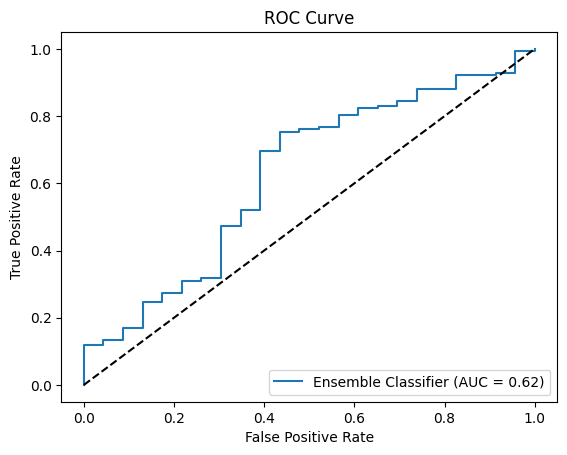

"Result": 1


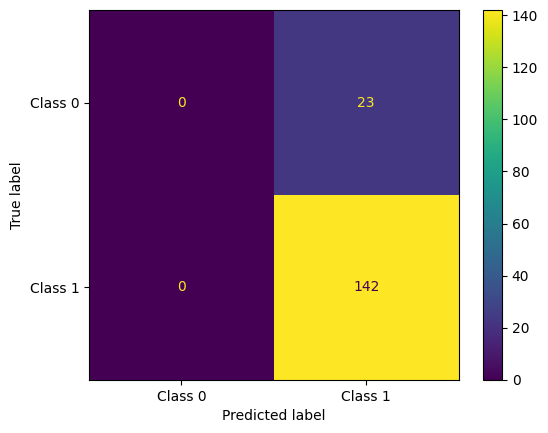

In [16]:
roc_cm(y_test, y_pred_proba)

In [17]:
"""generate_cm1(y_test,y_pred_binary, "RandomForestClassifier")
print("score from custom scorer: ", custom_scorer(y_test, y_pred_binary))



# Compute the accuracy score on the test data
rmse = mean_squared_error(y_test, y_pred[:,1])**0.5
print(f"Mean squared error: {rmse}")

print("y_pred[:,1]", y_pred[:,1])

y_pred_binary = np.where(y_pred[:,1] >= 0.5, 1, 0)
print("y_pred_binary", y_pred_binary)
print("y_test", np.array(y_test).ravel())
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy on test data:", accuracy)

generate_cm1(y_test, y_pred_binary, "RandomForestClassifier")
print("score from custom scorer: ", custom_scorer(y_test, y_pred_binary))

print(y_pred_binary.dtype)"""


'generate_cm1(y_test,y_pred_binary, "RandomForestClassifier")\nprint("score from custom scorer: ", custom_scorer(y_test, y_pred_binary))\n\n\n\n# Compute the accuracy score on the test data\nrmse = mean_squared_error(y_test, y_pred[:,1])**0.5\nprint(f"Mean squared error: {rmse}")\n\nprint("y_pred[:,1]", y_pred[:,1])\n\ny_pred_binary = np.where(y_pred[:,1] >= 0.5, 1, 0)\nprint("y_pred_binary", y_pred_binary)\nprint("y_test", np.array(y_test).ravel())\naccuracy = accuracy_score(y_test, y_pred_binary)\nprint("Accuracy on test data:", accuracy)\n\ngenerate_cm1(y_test, y_pred_binary, "RandomForestClassifier")\nprint("score from custom scorer: ", custom_scorer(y_test, y_pred_binary))\n\nprint(y_pred_binary.dtype)'

# ElasticNetCV 


1.   Simple native algorithm
2. One Hot encoding




In [18]:
"""# ElasticNetCV model
l1_ratios = np.linspace(0.01,0.99, 100)
model = ElasticNetCV(l1_ratio=l1_ratios, 
                     n_alphas=100, 
                     cv=10, 
                     max_iter=1000,
                     random_state=42, 
                     n_jobs=-1)
model.fit(X_train_ohe, y_train.squeeze())

# Prediction and evaluation
y_pred = model.predict(X_test_ohe)
rmse = mean_squared_error(y_test, y_pred)**0.5

# Compute the accuracy score on the test data
y_pred_binary = np.where(y_pred >= 0.5, 1, 0)
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy on test data:", accuracy)

print(f"Optimal l1_ratio: {model.l1_ratio_}")
print(f"Optimal alpha: {model.alpha_}")
print(f"Mean squared error: {rmse}")


ela_best_params = model.get_params()

path = "/content/drive/MyDrive/Colab Notebooks/Pickles"
# name of the pickle file
filename = "ela_best_params.pkl"

# save the pickle file
with open(f"{path}/{filename}", "wb") as f:
    pickle.dump(ela_best_params, f)




generate_cm1(y_test, y_pred_binary, "ElasticnetCV")
"""



'# ElasticNetCV model\nl1_ratios = np.linspace(0.01,0.99, 100)\nmodel = ElasticNetCV(l1_ratio=l1_ratios, \n                     n_alphas=100, \n                     cv=10, \n                     max_iter=1000,\n                     random_state=42, \n                     n_jobs=-1)\nmodel.fit(X_train_ohe, y_train.squeeze())\n\n# Prediction and evaluation\ny_pred = model.predict(X_test_ohe)\nrmse = mean_squared_error(y_test, y_pred)**0.5\n\n# Compute the accuracy score on the test data\ny_pred_binary = np.where(y_pred >= 0.5, 1, 0)\naccuracy = accuracy_score(y_test, y_pred_binary)\nprint("Accuracy on test data:", accuracy)\n\nprint(f"Optimal l1_ratio: {model.l1_ratio_}")\nprint(f"Optimal alpha: {model.alpha_}")\nprint(f"Mean squared error: {rmse}")\n\n\nela_best_params = model.get_params()\n\npath = "/content/drive/MyDrive/Colab Notebooks/Pickles"\n# name of the pickle file\nfilename = "ela_best_params.pkl"\n\n# save the pickle file\nwith open(f"{path}/{filename}", "wb") as f:\n    pick

# LGBM Classifier 


1.   Optuna - XXX algorithm 
2.   cross_val with StratKFold
3. Scoring Neg Log loss
4. 



LGBM classfier with cagtegorical features

In [19]:
"""
def custom_scorer(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn*40 -(fn * 8) - 3*fp

def objective_lgbm(trial, X, y):
    
    lgbm_params = {
      'objective': 'binary',
      'boosting_type': trial.suggest_categorical("boosting_type",['gbdt', 'dart']),
      "metric": "binary_logloss",
      'max_depth': trial.suggest_int('max_depth', 5, 20),
      'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3),
      'num_leaves': trial.suggest_int('num_leaves', 20, 80),
      'min_child_samples': trial.suggest_int('min_child_samples', 5, 30),
      'min_child_weight': trial.suggest_float('min_child_weight', 1e-5, 100),
      'subsample': trial.suggest_float('subsample', 0.1, 1.0, step=0.1),
      'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
      'reg_alpha': trial.suggest_float('reg_alpha', 0, 10, step=0.1),
      'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
      'min_split_gain': trial.suggest_float('min_split_gain', 0, 1),
      'max_bin': trial.suggest_int('max_bin', 300, 800),
      'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
      'verbosity': -1,
      'seed': 42
    }


    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    num_boost_round = trial.suggest_int('num_boost_round', 50, 1000)
    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        lgbm_train = lgbm.Dataset(X_train, y_train, params= lgbm_params,  free_raw_data=False)
        lgbm_test = lgbm.Dataset(X_test, y_test, params=lgbm_params,  free_raw_data=False, reference=lgbm_train)
        
        init_gbm = lgbm.train(lgbm_params, 
                           lgbm_train,
                           )
        
        model = lgbm.train(lgbm_params, lgbm_train,
                          valid_sets=lgbm_test,  # <-------
                          verbose_eval=False,
                          init_model=init_gbm,
                          num_boost_round = num_boost_round,
                          categorical_feature=cat_col_indices, #,log_evaluation(period=0)
                          callbacks=[early_stopping(stopping_rounds=100, first_metric_only=False, verbose = False)],
                          
        )
        y_preds = model.predict(X_test)
        y_pred_binary = np.where(y_preds >= 0.5, 1, 0)
        cv_scores[idx] = custom_scorer(y_test, y_pred_binary)
    return np.mean(cv_scores)
    
starting_lgbm_hp = {
  
}
#optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
#optuna.logging.set_verbosity(10)
study = optuna.create_study(direction='maximize', 
                            sampler=optuna.samplers.NSGAIISampler()
                            )
logging.basicConfig(level=logging.INFO)
# Get the logger object used by optuna and add the filter to it
logger = logging.getLogger("optuna.integration.lightgbm")
logger.addFilter(CustomFilter())

#study.enqueue_trial(starting_lgbm_hp)
study.optimize(lambda trial: objective_lgbm(trial, X_train, y_train), 
               n_trials=30, 
               show_progress_bar=True)

best_params = study.best_params
print(f"Best log loss: {study.best_value:.4f}")
print(f"Best params: {best_params}")

lgbm_train = lgbm.Dataset(X_train, y_train,  categorical_feature=cat_cols, free_raw_data=False)
lgbm_test = lgbm.Dataset(X_test, categorical_feature=cat_cols, reference=lgbm_train, free_raw_data=False)

init_gbm = lgbm.train(best_params, 
                      lgbm_train,
                      )
        
lgbm_clf = lgbm.train(best_params, lgbm_train,
                  valid_sets=lgbm_test,  # <-------
                  verbose_eval=False,
                  init_model=init_gbm,
                  categorical_feature=cat_col_indices, #,log_evaluation(period=0)
                  callbacks=[early_stopping(stopping_rounds=100, first_metric_only=False, verbose = False)],

                  )
y_pred = lgbm_clf.predict(X_test)

y_pred_binary = [1 if p > 0.5 else 0 for p in y_pred]
print("y_pred_binary_len: ", len(y_pred_binary))
print("y_test shape: ", y_test.shape)
accuracy = sum(y_pred_binary == y_test.squeeze()) / len(y_test)
print(f"Accuracy on test set: {accuracy:.4f}")

generate_cm1(y_test, lgbm_clf.predict(X_test), "XGBoost, optuna - cv, Validation Set")

y_pred = lgbm_clf.predict(X_train)

y_pred_binary = [1 if p > 0.5 else 0 for p in y_pred]
print("y_pred_binary_len: ", len(y_pred_binary))
print("y_test shape: ", y_train.shape)
accuracy = sum(y_pred_binary == y_train.squeeze()) / len(y_train)
print(f"Accuracy on test set: {accuracy:.4f}")

generate_cm1(y_train, lgbm_clf.predict(X_train), "XGBoost, optuna - cv, Validation Set")


lgbm_best_trial = study.best_trial
lgbm_best_params = lgbm_best_trial.params

print(f"Best score: {lgbm_best_trial.value:.4f}")
print(f"Best params: {lgbm_best_params}")

path = "/content/drive/MyDrive/Colab Notebooks/Pickles"
# name of the pickle file
filename = "lgbm_best_params.pkl"

# save the pickle file
with open(f"{path}/{filename}", "wb") as f:
    pickle.dump(lgbm_best_params, f)






print("Counter - test", y_test.value_counts())




"""

'\ndef custom_scorer(y_true, y_pred):\n    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()\n    return tn*40 -(fn * 8) - 3*fp\n\ndef objective_lgbm(trial, X, y):\n    \n    lgbm_params = {\n      \'objective\': \'binary\',\n      \'boosting_type\': trial.suggest_categorical("boosting_type",[\'gbdt\', \'dart\']),\n      "metric": "binary_logloss",\n      \'max_depth\': trial.suggest_int(\'max_depth\', 5, 20),\n      \'learning_rate\': trial.suggest_float(\'learning_rate\', 1e-3, 0.3),\n      \'num_leaves\': trial.suggest_int(\'num_leaves\', 20, 80),\n      \'min_child_samples\': trial.suggest_int(\'min_child_samples\', 5, 30),\n      \'min_child_weight\': trial.suggest_float(\'min_child_weight\', 1e-5, 100),\n      \'subsample\': trial.suggest_float(\'subsample\', 0.1, 1.0, step=0.1),\n      \'colsample_bytree\': trial.suggest_float(\'colsample_bytree\', 0.1, 1.0),\n      \'reg_alpha\': trial.suggest_float(\'reg_alpha\', 0, 10, step=0.1),\n      \'reg_lambda\': trial.suggest_f

#LGBM classifier with OHE

In [ ]:
def custom_scorer(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn*20 -(fn * 8) - 3*fp

def objective_lgbm(trial, X, y):
    
    lgbm_params = {
      'objective': 'binary',
      'boosting_type': 'gbdt',
      "metric": "binary_logloss",
      'max_depth': trial.suggest_int('max_depth', 5, 20),
      'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3),
      'num_leaves': trial.suggest_int('num_leaves', 20, 80),
      'min_child_samples': trial.suggest_int('min_child_samples', 5, 30),
      'min_child_weight': trial.suggest_float('min_child_weight', 1e-5, 100),
      'subsample': trial.suggest_float('subsample', 0.1, 1.0, step=0.1),
      'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
      'reg_alpha': trial.suggest_float('reg_alpha', 0, 10, step=0.1),
      'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
      'min_split_gain': trial.suggest_float('min_split_gain', 0, 1),
      'max_bin': trial.suggest_int('max_bin', 300, 800),
      'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
      'verbosity': -1,
      'seed': 42
    }


    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    num_boost_round = trial.suggest_int('num_boost_round', 50, 1000)
    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        lgbm_train = lgbm.Dataset(X_train, y_train, params= lgbm_params,  free_raw_data=False)
        lgbm_test = lgbm.Dataset(X_test, y_test, params=lgbm_params,  free_raw_data=False, reference=lgbm_train)
        
        init_gbm = lgbm.train(lgbm_params, 
                           lgbm_train,
                           )
        
        model = lgbm.train(lgbm_params, lgbm_train,
                          valid_sets=lgbm_test,  # <-------
                          
                          init_model=init_gbm,
                          num_boost_round = num_boost_round,
                          #,log_evaluation(period=0)
                          callbacks=[early_stopping(stopping_rounds=100, first_metric_only=False, verbose = False), log_evaluation(period=0)],
                          
        )
        y_preds = model.predict(X_test)
        y_pred_binary = np.where(y_preds >= 0.5, 1, 0)
        cv_scores[idx] = custom_scorer(y_test, y_pred_binary)
    return np.mean(cv_scores)
    
starting_lgbm_hp = {
  
}
#optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
#optuna.logging.set_verbosity(10)
study = optuna.create_study(direction='maximize', 
                            sampler=optuna.samplers.NSGAIISampler()
                            )
logging.basicConfig(level=logging.INFO)
# Get the logger object used by optuna and add the filter to it
logger = logging.getLogger("optuna.integration.lightgbm")
logger.addFilter(CustomFilter())
print("X_ttrain_ohe_shape", X_train_ohe.shape)
print("y_train.sahpe", y_train.shape)
#study.enqueue_trial(starting_lgbm_hp)
study.optimize(lambda trial: objective_lgbm(trial, X_train_ohe, y_train), 
               n_trials=3000, 
               show_progress_bar=True)

best_params = study.best_params
print(f"Best log loss: {study.best_value:.4f}")
print(f"Best params: {best_params}")

lgbm_train = lgbm.Dataset(X_train_ohe, y_train,  free_raw_data=False)
lgbm_test = lgbm.Dataset(X_test_ohe,  reference=lgbm_train, free_raw_data=False)

init_gbm = lgbm.train(best_params, 
                      lgbm_train,
                      )
        
lgbm_clf = lgbm.train(best_params, lgbm_train,
                  valid_sets=lgbm_test,  # <-------

                  init_model=init_gbm, 
                  callbacks=[early_stopping(stopping_rounds=100, first_metric_only=False), log_evaluation(period=0)],
                  )
y_pred = lgbm_clf.predict(X_test_ohe)

y_pred_binary = [1 if p > 0.5 else 0 for p in y_pred]
print("y_pred_binary_len: ", len(y_pred_binary))
print("y_test shape: ", y_test.shape)
accuracy = sum(y_pred_binary == y_test.squeeze()) / len(y_test)
print(f"Accuracy on test set: {accuracy:.4f}")

generate_cm1(y_test, lgbm_clf.predict(X_test_ohe), "XGBoost, optuna - cv, Validation Set")

y_pred = lgbm_clf.predict(X_train_ohe)

y_pred_binary = [1 if p > 0.5 else 0 for p in y_pred]
print("y_pred_binary_len: ", len(y_pred_binary))
print("y_test shape: ", y_train.shape)
accuracy = sum(y_pred_binary == y_train.squeeze()) / len(y_train)
print(f"Accuracy on test set: {accuracy:.4f}")

generate_cm1(y_train, lgbm_clf.predict(X_train_ohe), "XGBoost, optuna - cv, Validation Set")


lgbm_best_trial = study.best_trial
lgbm_best_params = lgbm_best_trial.params

print(f"Best score: {lgbm_best_trial.value:.4f}")
print(f"Best params: {lgbm_best_params}")

path = "/content/drive/MyDrive/Colab Notebooks/Pickles"
# name of the pickle file
filename = "lgbm_best_params.pkl"

# save the pickle file
with open(f"{path}/{filename}", "wb") as f:
    pickle.dump(lgbm_best_params, f)






print("Counter - test", y_test.value_counts())

[I 2023-04-12 06:25:49,884] A new study created in memory with name: no-name-8a9a66df-f601-4681-a346-a44621244b19


X_ttrain_ohe_shape (931, 108)
y_train.sahpe (931, 1)


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/3000 [00:00<?, ?it/s]

[I 2023-04-12 06:25:51,349] Trial 0 finished with value: -78.0 and parameters: {'max_depth': 8, 'learning_rate': 0.14050830508587717, 'num_leaves': 49, 'min_child_samples': 16, 'min_child_weight': 18.161901231177755, 'subsample': 0.8, 'colsample_bytree': 0.32913134489811535, 'reg_alpha': 4.5, 'reg_lambda': 8.635790098056438, 'min_split_gain': 0.31084304732205814, 'max_bin': 348, 'bagging_freq': 10, 'num_boost_round': 250}. Best is trial 0 with value: -78.0.
[I 2023-04-12 06:25:51,614] Trial 1 finished with value: -78.0 and parameters: {'max_depth': 18, 'learning_rate': 0.27192830662158163, 'num_leaves': 27, 'min_child_samples': 30, 'min_child_weight': 15.409263093478938, 'subsample': 0.8, 'colsample_bytree': 0.12276152166759206, 'reg_alpha': 4.7, 'reg_lambda': 4.736498711499307, 'min_split_gain': 0.7396781416518375, 'max_bin': 613, 'bagging_freq': 10, 'num_boost_round': 325}. Best is trial 0 with value: -78.0.
[I 2023-04-12 06:25:52,020] Trial 2 finished with value: -78.0 and parameter

#XGB classifier with categorical data

In [ ]:




def objective_xgb(trial,study, X, y):
    
    xgb_params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.1, 0.6),
        "tree_method": "hist",
        'objective': 'binary:logistic',
        "eval_metric": "logloss",
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 0.4),
        "alpha": trial.suggest_float("alpha", 1e-8, 0.6),
        "reg_alpha": trial.suggest_float("alpha", 1e-8, 0.6),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 0.4),
        "verbosity": 0
    }

    if xgb_params["booster"] == "gbtree" or xgb_params["booster"] == "dart":
        xgb_params["max_depth"] = trial.suggest_int("max_depth", 1, 16)
        xgb_params["eta"] = trial.suggest_float("eta", 1e-8, 0.6)
        xgb_params["gamma"] = trial.suggest_float("gamma", 1e-8, 0.6)
        xgb_params["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if xgb_params["booster"] == "dart":
        xgb_params["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        xgb_params["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        xgb_params["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 0.6)
        xgb_params["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 0.6)

    
   
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    num_boost_round = trial.suggest_int('num_boost_round', 50, 1000)
    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
        dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

      
        # Train the model using the custom objective and evaluation metric
        bst = xgb.train(xgb_params,
                        dtrain,
                        num_boost_round=num_boost_round,
                        evals=[(dtrain, 'train'), (dtest, 'test')],
                        early_stopping_rounds=10,
                        maximize=True,
                        verbose_eval=False
        )

        y_preds = bst.predict(dtest)
        y_pred_binary = np.where(y_preds >= 0.5, 1, 0)
        cv_scores[idx] = custom_scorer_xgb(y_test, y_pred_binary)
    return np.mean(cv_scores)

        

starting_xgb_hp = {
    'learning_rate': 0.07937792496092369, 
    'min_child_weight': 1, 
    'subsample': 0.5072873601156911, 
    'booster': 'gbtree', 
    'lambda': 0.2101881276876542, 
    'alpha': 0.1022775152443601, 
    'reg_lambda': 0.15380633163734847, 
    'max_depth': 6, 
    'eta': 0.25908426274659535, 
    'gamma': 0.46906789773943747, 
    'grow_policy': 'lossguide', 
    'num_boost_round': 368
}
study = optuna.create_study(direction='maximize', 
                            sampler=optuna.samplers.NSGAIISampler(), 
                            )
optuna.logging.set_verbosity(0)

study.enqueue_trial(starting_xgb_hp)
study.optimize(lambda trial: objective_xgb(trial, study, X_train, y_train), 
               n_trials=600, 
               show_progress_bar=True)


xgb_best_trial = study.best_trial
xgb_best_params = xgb_best_trial.params

print(f"Best score: {xgb_best_trial.value:.4f}")
print(f"Best params: {xgb_best_params}")

path = "/content/drive/MyDrive/Colab Notebooks/Pickles"
# name of the pickle file
filename = "xgb_best_params.pkl"

# save the pickle file
with open(f"{path}/{filename}", "wb") as f:
    pickle.dump(lgbm_best_params, f)


#xgb_clf = XGBClassifier(**xgb_best_params, tree_method="gpu_hist", enable_categorical=True, max_to_one_hot=1)
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical = True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical = True)
evals = [(dtrain, 'train'), (dtest, 'test')]
xgb_clf = xgb.train(xgb_best_params, dtrain, num_boost_round=1000, early_stopping_rounds=20, evals=evals)


generate_cm1(y_test, xgb_clf.predict(dtest), "XGBoost, optuna - cv, Validation Set")


print("Counter - test", y_test.value_counts())
"""


#XGB classifier with one hot encoded data

In [ ]:
def objective_xgb(trial, X, y):
    
    xgb_params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, .4),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 16),
        'subsample': trial.suggest_float('subsample', 0.1, 0.6),
        "tree_method": "hist",
        'objective': 'binary:logitraw',
        "eval_metric": trial.suggest_categorical("eval_metric", ["logloss", "error"]),
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 0.4),
        "alpha": trial.suggest_float("alpha", 1e-8, 0.6),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 0.6),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 0.4),
        "verbosity": 0
    }

    if xgb_params["booster"] == "gbtree" or xgb_params["booster"] == "dart":
        xgb_params["max_depth"] = trial.suggest_int("max_depth", 1, 32)
        xgb_params["eta"] = trial.suggest_float("eta", 1e-8, 0.6)
        xgb_params["gamma"] = trial.suggest_float("gamma", 1e-8, 0.6)
        xgb_params["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    if xgb_params["booster"] == "dart":
        xgb_params["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        xgb_params["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        xgb_params["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 0.6)
        xgb_params["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 0.6)
    
   
    
    
    
    cv_scores = np.empty(5)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    num_boost_round = trial.suggest_int('num_boost_round', 50, 2000)
    
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        xgb_clf_ohe = XGBClassifier(**xgb_best_params_ohe, 
                                    random_state=42, 
                                    n_jobs=-1,
                                    early_stopping_rounds = 20, 
                          )
        eval_set = [(X_test, y_test)]
        xgb_clf_ohe.fit(X_train, y_train, eval_set=eval_set, verbose=False)
        
        
        
        y_preds = xgb_clf_ohe.predict(X_test)
        y_pred_binary = np.where(y_preds >= 0.5, 1, 0)
        cv_scores[idx] = custom_scorer_xgb(y_test, y_pred_binary)
    
    
    return np.mean(cv_scores)

        

starting_xgb_hp = {
    'learning_rate': 0.05084159333221825, 
    'min_child_weight': 3, 
    'subsample': 0.3871337830307525, 
    'eval_metric': 'error', 
    'booster': 'gbtree', 
    'objective': 'binary:logitraw',
    'lambda': 0.23147830243654424, 
    'alpha': 0.30992078732377804, 
    'reg_alpha': 0.17310497412687864, 
    'reg_lambda': 0.08863091609578484, 
    'max_depth': 24, 
    'eta': 0.3362838762553205, 
    'gamma': 0.1850934562272251, 
    'grow_policy': 'depthwise', 
    'num_boost_round': 237
}
study = optuna.create_study(direction='maximize', 
                            sampler=optuna.samplers.NSGAIISampler(), 
                            )
optuna.logging.set_verbosity(0)

study.enqueue_trial(starting_xgb_hp)
study.optimize(lambda trial: objective_xgb(trial, X_train_ohe, y_train), 
               n_trials=100, 
               show_progress_bar=True)


xgb_best_trial_ohe = study.best_trial
xgb_best_params_ohe = xgb_best_trial_ohe.params

print(f"Best score: {xgb_best_trial_ohe.value:.4f}")
print(f"Best params: {xgb_best_params_ohe}")

path = "/content/drive/MyDrive/Colab Notebooks/Pickles"
# name of the pickle file
filename = "xgb_best_params_ohe.pkl"

# save the pickle file
with open(f"{path}/{filename}", "wb") as f:
    pickle.dump(xgb_best_params_ohe, f)


#xgb_clf = XGBClassifier(**xgb_best_params, tree_method="gpu_hist", enable_categorical=True, max_to_one_hot=1)
dtrain = xgb.DMatrix(X_train_ohe, label=y_train)
dtest = xgb.DMatrix(X_test_ohe, label=y_test)
evals = [(dtrain, 'train'), (dtest, 'test')]
xgb_clf_ohe = XGBClassifier (**xgb_best_params_ohe, random_state = 42, n_jobs = -1)
xgb_clf_ohe.fit(X_train_ohe, y_train)

generate_cm1(y_test, xgb_clf_ohe.predict(X_test_ohe), "XGBoost, optuna - cv, Validation Set")


print("Counter - test", y_test.value_counts())

In [ ]:
y_pred = xgb_clf_ohe.predict(X_test_ohe)
y_pred = (y_pred > 0.5).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print("confusion Matrix validation")
print("tn: ", tn, "fp: ", fp, "fn: ", fn, "tp: ", tp)

# Catboost classifier OHE

In [ ]:
def custom_loss(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return (tn * 10) - (fn * 9) - fp

class CustomObjective:
    def calc_ders_range(self, approxes, targets, weights=None, start_idx=0, end_idx=None):
        y_true = targets[start_idx:end_idx]
        y_pred = approxes[0][start_idx:end_idx]
        tn, fp, fn, tp = confusion_matrix(y_true, np.round(y_pred)).ravel()
        grad = np.where(y_true == y_pred, -9, 10)
        hess = np.zeros_like(grad)
        return grad, hess

# Define the objective function for Optuna
def objective_catboost(trial, X, y):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'depth': trial.suggest_int('depth', 2, 10),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 5, 200),
        'random_strength': trial.suggest_int('random_strength', 1, 20),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.01, 100.00),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'max_ctr_complexity': trial.suggest_int('max_ctr_complexity', 1, 10),
        'task_type': 'CPU'
    }
    
    
    skf = StratifiedKFold(n_splits=5, 
                          shuffle=True, 
                          random_state=42)
    
    # Train and evaluate the model using cross-validation
    scores = []
    for train_idx, val_idx in skf.split(X, y):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
        
        # Create a Pool object
        pool_train = Pool(data=X_train, label=y_train)
        pool_valid = Pool(data=X_val, label=y_val)
        
        # Train the model
        model = CatBoostClassifier(**params, eval_metric='F1', random_state=42)
        model.fit(pool_train, eval_set=pool_valid, verbose=False)
        
        # Evaluate the model on the validation set
        y_pred = model.predict(X_val)
        y_pred = (y_pred > 0.5).astype(int)
        score = custom_loss(y_val, y_pred)
        scores.append(score)

    return np.mean(scores)

#Starting hyperparamters to improve convergence
starting_cat_hp = {'iterations': 692, 
                   'learning_rate': 0.2884712156343811, 
                   'depth': 2, 
                   'l2_leaf_reg': 4, 
                   'border_count': 56, 
                   'random_strength': 5, 
                   'bagging_temperature': 97.30132536969704, 
                   'grow_policy': 'Depthwise', 
                   'max_ctr_complexity': 8
}

# Optimize hyperparameters

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.NSGAIISampler())
study.enqueue_trial(starting_cat_hp)
study.optimize(lambda trial: objective_catboost(trial, X_train_ohe,y_train), n_trials=100)

# Get best parameters
cat_best_params = study.best_params
print("Best parameters: ", cat_best_params)

#Pool variables to be used with catboost:
pool_train = Pool(X_train_ohe, y_train)

pool_test = Pool(X_test_ohe)


# Run the randomized search
# best parameters: iterations': 420, 'learning_rate': 0.18951730321390894, 'depth': 2, 'l2_leaf_reg': 2, 'border_count': 44, 'random_strength': 11, 'bagging_temperature': 59.24553274051562, 'grow_policy': 'SymmetricTree', 'max_ctr_complexity': 5
cb_classifier = CatBoostClassifier(**cat_best_params, random_state=42, verbose=0)
cb_classifier.fit(pool_train)
tn, fp, fn, tp = confusion_matrix(y_test, cb_classifier.predict(X_test_ohe)).ravel()
print("confusion Matrix test")
print("tn: ", tn, "fp: ", fp, "fn: ", fn, "tp: ", tp)
generate_cm1(y_test, cb_classifier.predict(pool_test), "CatBoost - Test")

# Save the best parameters for CatBoost
path = "/content/drive/MyDrive/Colab Notebooks/Pickles"
# name of the pickle file
filename = "cat_best_params.pkl"

# save the pickle file
with open(f"{path}/{filename}", "wb") as f:
    pickle.dump(cat_best_params, f)

# Clear memory
del cb_classifier
gc.collect()

#Load best params via pickles

In [ ]:
def load_best_params(path = None):
    """
    Load the best hyperparameters for each classifier from pickle files.

    Returns:
    --------
    Tuple:
        A tuple containing the best hyperparameters for XGBoost, LightGBM, CatBoost, and Random Forest classifiers.
    """
    if path == None: 
      path = "/content/drive/MyDrive/Colab Notebooks/Pickles"

    # Load the best parameters for each classifier
    with open(os.path.join(path, "lgbm_best_params.pkl"), "rb") as f:
        lgbm_best_params = pickle.load(f)

    with open(os.path.join(path, "xgb_best_params.pkl"), "rb") as f:
        xgb_best_params = pickle.load(f)

    with open(os.path.join(path, "cat_best_params.pkl"), "rb") as f:
        cat_best_params = pickle.load(f)

    with open(os.path.join(path, "rf_best_params.pkl"), "rb") as f:
        rf_best_params = pickle.load(f)

    return [xgb_best_params, lgbm_best_params, cat_best_params, rf_best_params]


#Voting Classifier

In [ ]:
#Load best params
best_params = load_best_params()

def votingclassification(X_train, y_train, X_test, params):
    """
    Trains and returns a soft-voting classifier ensemble of several machine learning models
    using the best hyperparameters found during optimization.

    Args:
        X_train (pandas.DataFrame): The input features for the training set.
        y_train (pandas.DataFrame): The target variable for the training set.
        X_test (pandas.DataFrame): The input features for the test set.
        params (tuple): A tuple containing xgb_best_params, lgbm_best_params, cat_best_params, rf_best_params.

    Returns:
        numpy.ndarray: The predicted target variable values for the test set.
    """
    # Extract the best hyperparameters for each model
    xgb_best_params, lgbm_best_params, cat_best_params, rf_best_params = params
    
    # Instantiate classifiers with the best parameters
    lgbm_clf = LGBMClassifier(random_state=42, **lgbm_best_params)
    xgb_clf = XGBClassifier(**xgb_best_params, random_state=42, tree_method='hist', n_jobs=-1)
    cat_clf = CatBoostClassifier(**cat_best_params, random_seed=42, verbose=False)
    rf_clf = RandomForestClassifier(random_state=42, **rf_best_params)

    # Create a soft-voting classifier
    ensemble_clf = VotingClassifier(estimators=[
        ('lgbm', lgbm_clf),
        ('xgb', xgb_clf),
        ('cat', cat_clf),
        ('rf', rf_clf)
    ], voting='soft')

    # Train the ensemble classifier
    ensemble_clf.fit(X_train, y_train.squeeze())
    
    # Predict target variable values for the test set
    y_pred = ensemble_clf.predict_proba(X_test)

    return y_pred_proba

y_pred_proba = votingclassification(X_train_ohe, y_train, X_test_ohe, best_params)




In [ ]:
roc_cm(y_test, y_pred_proba)

Addition of feauture reduction methods

Use stacking method to combine the results of different models
Extra trees classifier and Principal component analysis

#Principal Component Analysis

In [ ]:
# Instantiate classifiers

lgbm_clf = LGBMClassifier(random_state=42, **lgbm_best_params)
xgb_clf = XGBClassifier(random_state=42, tree_method='hist', n_jobs=-1, **xgb_best_params)
cat_clf = CatBoostClassifier(task_type="CPU", random_seed=42, **cat_best_params)
rf_clf = RandomForestClassifier(random_state=42, **rf_best_params)


# Create pipelines with PCA and classifiers
pipelines = {
    'LightGBM': Pipeline([('pca', PCA()), ('clf', lgbm_clf)]),
    'XGBoost': Pipeline([('pca', PCA()), ('clf', xgb_clf)]),
    'CatBoost': Pipeline([('pca', PCA()), ('clf', cat_clf)]),

    'Random Forest': Pipeline([('pca', PCA()), ('clf', rf_clf)]),
    
}



In [ ]:
cv_results = []

def macro_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')

macro_f1_scorer = make_scorer(macro_f1, greater_is_better = True)

for name, pipeline in pipelines.items():
    scores = cross_val_score(pipeline, X_train_ohe, y_train, cv=5, scoring=macro_f1_scorer, n_jobs=-1)
    cv_results.append((name, scores.mean(), scores.std()))

cv_results.sort(key=lambda x: x[1], reverse=True)

print("Classifier performance using cross-validation:")
for name, mean_score, std_dev in cv_results:
    print(f"{name}: {mean_score:.4f} (+/- {std_dev:.4f})")



# Stacking classifiers

In [ ]:
def stacking_classification(X_train, y_train, X_test, best_params):
    """
    Stacking classifier with LightGBM, XGBoost, CatBoost, and Random Forest as base estimators and XGBoost as meta-estimator.

    Args:
        X_train (DataFrame): One-Hot-Encoded Training data features.
        y_train (Series): Training data targets.
        X_test (DataFrame): One-Hot-Encoded Test data features.
        best_params (tuple): Tuple of best parameters for each classifier.

    Returns:
        ndarray: Predicted class probabilities for test data.
    """

    # Instantiate classifiers
    xgb_best_params, lgbm_best_params, cat_best_params, rf_best_params = best_params
  
    lgbm_clf = LGBMClassifier(random_state=42, **lgbm_best_params)
    xgb_clf = XGBClassifier(random_state=42, tree_method='gpu_hist', n_jobs=-1, **xgb_best_params)
    cat_clf = CatBoostClassifier(task_type="GPU", random_seed=42, **cat_best_params)
    rf_clf = RandomForestClassifier(random_state=42, **rf_best_params)

    base_classifiers = [
        ('LightGBM', lgbm_clf),
        ('XGBoost', xgb_clf),
        ('CatBoost', cat_clf),
        ('Random Forest', rf_clf), 
    ]

    meta_classifier = XGBClassifier(random_state=42)
    stacking_clf = StackingClassifier(estimators=base_classifiers, final_estimator=meta_classifier)

    stacking_scores = cross_val_score(stacking_clf, X_train, y_train, cv=5, scoring=custom_scorer_xgb, n_jobs=-1)

    print("Stacking Classifier performance:")
    print(f"Mean recall: {stacking_scores.mean():.4f}, Standard deviation: {stacking_scores.std():.4f}")

    stacking_clf.fit(X_train, y_train)
    y_pred_proba = stacking_clf.predict_proba(X_test)

    return y_pred_proba


In [ ]:
roc_cm(y_test, y_pred_proba)

In [ ]:
class Splitter:
    def __init__(self, n_splits=5):
        self.n_splits = n_splits
        self.kfold = True

    def split_data(self, X, y, random_state_list):
        
        for random_state in random_state_list:
            kf = StratifiedKFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
            for train_index, val_index in kf.split(X, y):
                X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                yield X_train, X_val, y_train, y_val
        

class Classifier:
    def __init__(self, n_estimators=100, device="cpu", random_state=0):
        self.n_estimators = n_estimators
        self.device = device
        self.random_state = random_state
        self.models = self._define_model()
        self.len_models = len(self.models)
        
    def _define_model(self):
        
        path = "/content/drive/MyDrive/Colab Notebooks/Pickles"

        # Load the best parameters for each classifier
        filename = "lgbm_best_params.pkl"
        with open(f"{path}/{filename}", "rb") as f:
          lgbm_best_params = pickle.load(f)

        filename = "xgb_best_params.pkl"
        with open(f"{path}/{filename}", "rb") as f:
          xgb_best_params = pickle.load(f)

        filename = "cat_best_params.pkl"
        with open(f"{path}/{filename}", "rb") as f:
          cat_best_params = pickle.load(f)

        filename = "rf_best_params.pkl"
        with open(f"{path}/{filename}", "rb") as f:
          rf_best_params = pickle.load(f)
        
        
        models = {
            'xgb': xgb.XGBClassifier(**xgb_best_params),
            'lgb': lgbm.LGBMClassifier(**lgbm_best_params),
            'cat': CatBoostClassifier(**cat_best_params),
            'rf': RandomForestClassifier(**rf_best_params),
        }
        
        return models

class OptunaWeights:
    def __init__(self, random_state):
        self.study = None
        self.weights = None
        self.random_state = random_state

    def _objective(self, trial, y_true, y_preds):
        # Define the weights for the predictions from each model
        weights = [trial.suggest_float(f"weight{n}", 0, 1) for n in range(len(y_preds))]

        # Calculate the weighted prediction
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=weights)

        # Calculate the AUC score for the weighted prediction
        score = roc_auc_score(y_true, weighted_pred)
        return score

    def fit(self, y_true, y_preds, n_trials=2000):
        optuna.logging.set_verbosity(optuna.logging.ERROR)
        sampler = optuna.samplers.CmaEsSampler(seed=self.random_state)
        self.study = optuna.create_study(sampler=sampler, study_name="OptunaWeights", direction='maximize')
        objective_partial = partial(self._objective, y_true=y_true, y_preds=y_preds)
        self.study.optimize(objective_partial, n_trials=n_trials)
        self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))]

    def predict(self, y_preds):
        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict'
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=self.weights)
        return weighted_pred

    def fit_predict(self, y_true, y_preds, n_trials=2000):
        self.fit(y_true, y_preds, n_trials=n_trials)
        return self.predict(y_preds)
    
    def weights(self):
        return self.weights

# Train weighted model

In [ ]:
kfold = True
n_splits = 1 if not kfold else 5
random_state = 42
random_state_list = [42] # used by split_data [71]
n_estimators = 3000 # 9999
early_stopping_rounds = 200
verbose = False
device = 'cpu'

splitter = Splitter(n_splits=n_splits)

# Initialize an array for storing test predictions
test_predss = np.zeros(X_test_ohe.shape[0])
ensemble_score = []
weights = []
trained_models = {'xgb':[], 'lgb':[], 'cat':[]}

    
for i, (X_train_, X_val, y_train_, y_val) in enumerate(splitter.split_data(X_train_ohe, y_train.squeeze(), random_state_list=random_state_list)):
    n = i % n_splits
    m = i // n_splits
            
    # Get a set of Regressor models
    classifier = Classifier(n_estimators, device, random_state)
    models = classifier.models
    
    # Initialize lists to store oof and test predictions for each base model
    oof_preds = []
    test_preds = []
    
    # Loop over each base model and fit it to the training data, evaluate on validation data, and store predictions
    for name, model in models.items():
        if name in ['xgb', 'lgb', 'cat']:
            model.fit(X_train_, y_train_, eval_set=[(X_val, y_val)], early_stopping_rounds=early_stopping_rounds, verbose=verbose)
            trained_models[f'{name}'].append(deepcopy(model))
        else:
            model.fit(X_train_, y_train_)
        
        test_pred = model.predict_proba(X_test_ohe)[:, 1]
        y_val_pred = model.predict_proba(X_val)[:, 1]

        score = roc_auc_score(y_val, y_val_pred)
        print(f'{name} [FOLD-{n} SEED-{random_state_list[m]}] AUC score: {score:.5f}')
        
        oof_preds.append(y_val_pred)
        test_preds.append(test_pred)
    
    # Use Optuna to find the best ensemble weights
    optweights = OptunaWeights(random_state=random_state)
    print("y_test.values: ", y_test.values.shape)
    
    y_val_pred = optweights.fit_predict(y_val.values, oof_preds)
    
    score = roc_auc_score(y_val, y_val_pred)
    print(f'Ensemble [FOLD-{n} SEED-{random_state_list[m]}] AUC score {score:.5f}')
    ensemble_score.append(score)
    weights.append(optweights.weights)
    
    test_predss += optweights.predict(test_preds) / (n_splits * len(random_state_list))
    
    gc.collect()

In [ ]:
# Calculate the mean LogLoss score of the ensemble
mean_score = np.mean(ensemble_score)
std_score = np.std(ensemble_score)
print(f'Ensemble Accuracy score {mean_score:.5f} ± {std_score:.5f}')

# Print the mean and standard deviation of the ensemble weights for each model
print('--- Model Weights ---')
mean_weights = np.mean(weights, axis=0)
std_weights = np.std(weights, axis=0)
for name, mean_weight, std_weight in zip(models.keys(), mean_weights, std_weights):
    print(f'{name}: {mean_weight:.5f} ± {std_weight:.5f}')

In [ ]:
generate_cm1(y_test, test_predss, "optuna_weights")
print(test_predss)

#Predictions

In [ ]:
data_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/loan_book_data_labels.csv")
labels = data_train["Result"]
data_train.drop("Result", axis=1, inplace=True)
X_train, X_val , y_train, y_val = preprocessing(data_train, labels, test_size = 0.15, smote = True)

data_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/prediction_dataset.csv")
X_test = preprocessing(data_test)

best_params = load_best_params("/content/drive/MyDrive/Colab Notebooks/Pickles_1GT")

In [ ]:
xgb_best_params, lgbm_best_params, cat_best_params, rf_best_params = best_params

y_pred_proba = stacking_classification(X_train, y_train, X_val, best_params)

In [ ]:
roc_cm(y_val, y_pred_proba)

#OOS predictions